## Fastiai Chapter 2 Deployment Write-up

### Importing needed dependencies
- Simply use dependencies in fastbook to easily and quickly import all libraries and modules needed

In [1]:
from fastbook import *
from fastai.vision.widgets import *

### Grabbing the images using Microsoft Azure
- In order to get your API_SEARCH_KEY, you need to first make a free account in Microsoft Azure
- Then, you need to head to https://portal.azure.com/#create/microsoft.bingsearch to create a Bing search resource
    - Resource group and instance name doesn't really matter, I just used Fastai and Chapter 2 respectively for the sake of organization
    - I left the tags blank as well
    - Then review + create
- After deployment, click on "Go to resource" > "Keys and Endpoint"
    - Use one of the two keys you are given
- Voila

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', '3fb150a318e3420daf9d0f3ca00e876c')
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl') #this gets all the URLs returned by the bing search and placing it in the ims list
len(ims)

150

### Testing images
- To see if you actually have the images, you can grab 1 URL from the 150 you have
- Set your destination path (e.g. in this case images/grizzly.jpg)
- download_url(image, path)
- Then, open the image and resize it to 128px by 128px and show it in the notebook

In [8]:
#when actually doing work, do not run this line, this will replace your 150 list with just this image
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [9]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

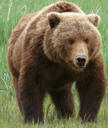

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

### Collecting and Storing the Data
- The bulk of the code is basically in the for loop which:
    1. Starts with making the destination path/directory for downloading the images
    2. Then results lists grabs all the images associated with the bear using search_images_bing with your api key
    3. Then downloads the images to the desination path with the names of each image being their URL
    4. This process is repeated for however many bear_types there are, in this case 3
- This procedure might take a few minutes as you have 150 images for each bear and you're downloading all of them locally into 3 separate directories

In [3]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))